In [18]:
# Import libraries
from urllib.request import urlopen, Request
from bs4 import BeautifulSoup
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# NLTK VADER for sentiment analysis
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

finwiz_url = 'https://finviz.com/quote.ashx?t='

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [19]:
news_tables = {}
tickers = ['AMZN', 'TSLA', 'GOOG']

for ticker in tickers:
    url = finwiz_url + ticker
    req = Request(url=url,headers={'user-agent': 'my-app/0.0.1'}) 
    response = urlopen(req)    
    # Read the contents of the file into 'html'
    html = BeautifulSoup(response)
    # Find 'news-table' in the Soup and load it into 'news_table'
    news_table = html.find(id='news-table')
    # Add the table to our dictionary
    news_tables[ticker] = news_table

In [20]:
# Read one single day of headlines for 'AMZN' 
amzn = news_tables['AMZN']
# Get all the table rows tagged in HTML with <tr> into 'amzn_tr'
amzn_tr = amzn.findAll('tr')

for i, table_row in enumerate(amzn_tr):
    # Read the text of the element 'a' into 'link_text'
    a_text = table_row.a.text
    # Read the text of the element 'td' into 'data_text'
    td_text = table_row.td.text
    # Print the contents of 'link_text' and 'data_text' 
    print(a_text)
    print(td_text)
    # Exit after printing 4 rows of data
    if i == 3:
        break

2 Top Stocks in Tech
Nov-01-20 06:00PM  
Small French Retailers Decry Closures During Lockdown
04:30PM  
Can the H-1B visa survive American nationalism?
10:30AM  
Better Buy: Baidu vs. MercadoLibre
09:29AM  


In [21]:
parsed_news = []

# Iterate through the news
for file_name, news_table in news_tables.items():
    # Iterate through all tr tags in 'news_table'
    for x in news_table.findAll('tr'):
        # read the text from each tr tag into text
        # get text from a only
        text = x.a.get_text() 
        # splite text in the td tag into a list 
        date_scrape = x.td.text.split()
        # if the length of 'date_scrape' is 1, load 'time' as the only element

        if len(date_scrape) == 1:
            time = date_scrape[0]
            
        # else load 'date' as the 1st element and 'time' as the second    
        else:
            date = date_scrape[0]
            time = date_scrape[1]
        # Extract the ticker from the file name, get the string up to the 1st '_'  
        ticker = file_name.split('_')[0]
        
        # Append ticker, date, time and headline as a list to the 'parsed_news' list
        parsed_news.append([ticker, date, time, text])
        
parsed_news

[['AMZN', 'Nov-01-20', '06:00PM', '2 Top Stocks in Tech'],
 ['AMZN',
  'Nov-01-20',
  '04:30PM',
  'Small French Retailers Decry Closures During Lockdown'],
 ['AMZN',
  'Nov-01-20',
  '10:30AM',
  'Can the H-1B visa survive American nationalism?'],
 ['AMZN', 'Nov-01-20', '09:29AM', 'Better Buy: Baidu vs. MercadoLibre'],
 ['AMZN',
  'Nov-01-20',
  '09:21AM',
  'Future Retail says Amazon dispute order not binding on company'],
 ['AMZN',
  'Nov-01-20',
  '09:13AM',
  "India's Future Retail says Amazon dispute order not binding on company"],
 ['AMZN',
  'Nov-01-20',
  '09:03AM',
  "India's Future Retail says Amazon dispute order not binding on company"],
 ['AMZN',
  'Nov-01-20',
  '09:00AM',
  '3 Reasons Alphabet Surged on Friday While the Rest of FAANG Plummeted'],
 ['AMZN',
  'Nov-01-20',
  '08:15AM',
  'Better Buy: Zoom Video Communications vs. Alphabet'],
 ['AMZN',
  'Nov-01-20',
  '07:36AM',
  'Is Now The Time To Put Amazon.com (NASDAQ:AMZN) On Your Watchlist?'],
 ['AMZN',
  'Nov-01-2

In [22]:
# Instantiate the sentiment intensity analyzer
vader = SentimentIntensityAnalyzer()

# Set column names
columns = ['ticker', 'date', 'time', 'headline']

# Convert the parsed_news list into a DataFrame called 'parsed_and_scored_news'
parsed_and_scored_news = pd.DataFrame(parsed_news, columns=columns)

# Iterate through the headlines and get the polarity scores using vader
scores = parsed_and_scored_news['headline'].apply(vader.polarity_scores).tolist()

# Convert the 'scores' list of dicts into a DataFrame
scores_df = pd.DataFrame(scores)

# Join the DataFrames of the news and the list of dicts
parsed_and_scored_news = parsed_and_scored_news.join(scores_df, rsuffix='_right')

# Convert the date column from string to datetime
parsed_and_scored_news['date'] = pd.to_datetime(parsed_and_scored_news.date).dt.date

parsed_and_scored_news.head()

,ticker,date,time,headline,neg,neu,pos,compound
0,AMZN,2020-11-01,06:00PM,2 Top Stocks in Tech,0.000,0.625,0.375,0.2023
1,AMZN,2020-11-01,04:30PM,Small French Retailers Decry Closures During L...,0.000,1.000,0.000,0.0000
2,AMZN,2020-11-01,10:30AM,Can the H-1B visa survive American nationalism?,0.000,1.000,0.000,0.0000
3,AMZN,2020-11-01,09:29AM,Better Buy: Baidu vs. MercadoLibre,0.000,0.580,0.420,0.4404
4,AMZN,2020-11-01,09:21AM,Future Retail says Amazon dispute order not bi...,0.218,0.645,0.137,-0.2500


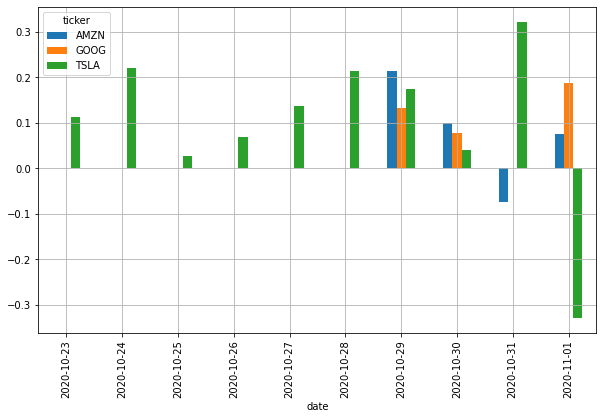

In [23]:
plt.rcParams['figure.figsize'] = [10, 6]

# Group by date and ticker columns from scored_news and calculate the mean
mean_scores = parsed_and_scored_news.groupby(['ticker','date']).mean()

# Unstack the column ticker
mean_scores = mean_scores.unstack()

# Get the cross-section of compound in the 'columns' axis
mean_scores = mean_scores.xs('compound', axis="columns").transpose()

# Plot a bar chart with pandas
mean_scores.plot(kind = 'bar')
plt.grid()